<a href="https://colab.research.google.com/github/pinilDissanayaka/Paddy-Doctor-Paddy-Disease-Classification/blob/main/XceptionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install livelossplot
!pip install visualkeras
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.2 MB/s eta 0:00:00


In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
! kaggle datasets download ricardosalvatorelli1/paddydoctor

Dataset URL: https://www.kaggle.com/datasets/ricardosalvatorelli1/paddydoctor
License(s): unknown
 99% 1.00G/1.02G [00:13<00:00, 97.2MB/s]
100% 1.02G/1.02G [00:13<00:00, 80.3MB/s]


In [4]:
! unzip paddydoctor.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/downy_mildew/100992.jpg  
  inflating: train_images/downy_mildew/100995.jpg  
  inflating: train_images/downy_mildew/101015.jpg  
  inflating: train_images/downy_mildew/101020.jpg  
  inflating: train_images/downy_mildew/101022.jpg  
  inflating: train_images/downy_mildew/101024.jpg  
  inflating: train_images/downy_mildew/101034.jpg  
  inflating: train_images/downy_mildew/101050.jpg  
  inflating: train_images/downy_mildew/101078.jpg  
  inflating: train_images/downy_mildew/101096.jpg  
  inflating: train_images/downy_mildew/101103.jpg  
  inflating: train_images/downy_mildew/101114.jpg  
  inflating: train_images/downy_mildew/101119.jpg  
  inflating: train_images/downy_mildew/101142.jpg  
  inflating: train_images/downy_mildew/101177.jpg  
  inflating: train_images/downy_mildew/101178.jpg  
  inflating: train_images/downy_mildew/101181.jpg  
  inflating: train_images/downy_mildew/101205.jpg  
  inflating: 

In [6]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import seaborn as sns
import cv2
import albumentations as A

from albumentations.core.composition import Compose
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Add, Activation
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from livelossplot import PlotLossesKeras

import warnings
warnings.filterwarnings(action = 'ignore')

In [7]:
import glob
from pathlib import Path

train_path = '/content/train_images'
test_path  = '/content/test_images'

print('train images')
for filepath in glob.glob(train_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

print('test images')
for filepath in glob.glob(test_path + '/*/'):
  files = glob.glob(filepath + '*')
  print(f"{len(files)} \t {Path(filepath).name}")

files = glob.glob(test_path + '/*')
print(f"{len(files)} \t {Path(test_path).name}")

train images
337 	 bacterial_panicle_blight
479 	 bacterial_leaf_blight
1442 	 dead_heart
1764 	 normal
380 	 bacterial_leaf_streak
965 	 brown_spot
1088 	 tungro
1738 	 blast
1594 	 hispa
620 	 downy_mildew
test images
3469 	 test_images


In [8]:
SEED = 123
EPOCHS = 100
lr = 1e-4
valid_split = 0.2
input_size = 224
batch_size = 32

n_classes = len(glob.glob(train_path + '/*/'))
print(n_classes)

10


In [9]:
generator = ImageDataGenerator(rescale=1 / 255,
                                  rotation_range=10,
                                  shear_range=0.25,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  validation_split=valid_split,
#                                   preprocessing_function=get_transforms_train
                                 )

train_datagen = generator.flow_from_directory(train_path,
                                              target_size=(input_size, input_size),
                                              batch_size=batch_size,
                                              subset='training',
                                              seed=SEED)

valid_datagen = generator.flow_from_directory(train_path,
                                              target_size=(input_size, input_size),
                                              batch_size=batch_size,
                                              subset='validation',
                                              seed=SEED)

test_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(directory=test_path,
                                                                    target_size=(input_size, input_size),
                                                                    batch_size=batch_size,
                                                                    #classes=['.'],
                                                                    shuffle=False,
                                                                    seed=SEED
                                                                   )

print(train_datagen.class_indices)
print(train_datagen.samples, valid_datagen.samples, test_generator.samples, )

Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.
Found 0 images belonging to 0 classes.
{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}
8330 2077 0


In [10]:
def create_model(input_size, n_classes):
    back_bone = tf.keras.applications.Xception(weights='imagenet', input_shape=(input_size,input_size,3), include_top=False)
    back_bone.summary()
    tf.keras.utils.plot_model(back_bone, to_file='xception.png')
    input_layer = Input(shape=(input_size,input_size,3))
    x = back_bone(input_layer)
    x = GlobalAveragePooling2D()(x)
    output_layer = Dense(n_classes, activation='softmax')(x)

    initializer = tf.keras.initializers.HeUniform()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = tf.keras.losses.categorical_crossentropy

    model = Model(input_layer,output_layer)
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    return model

model = create_model(input_size, n_classes)
model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activat

In [11]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=15,
                                              monitor='val_loss',
                                              restore_best_weights=True,
                                              verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=5,
                                                 monitor='val_loss',
                                                 factor=0.75,
                                                 verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='xception.weights.best.hdf5',
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

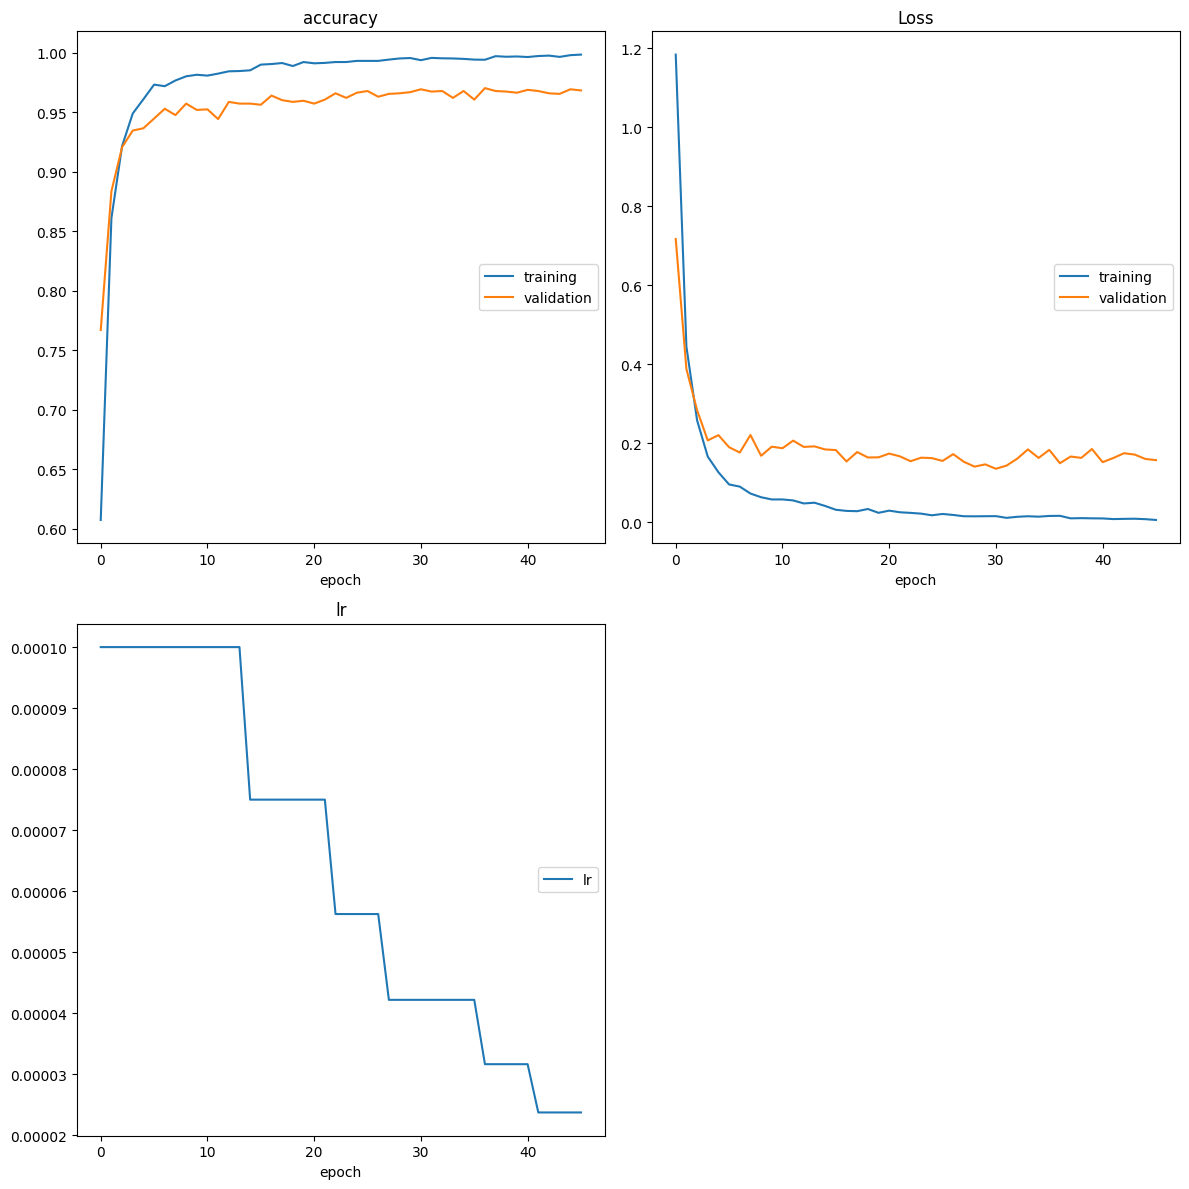

accuracy
	training         	 (min:    0.607, max:    0.998, cur:    0.998)
	validation       	 (min:    0.767, max:    0.970, cur:    0.968)
Loss
	training         	 (min:    0.005, max:    1.183, cur:    0.005)
	validation       	 (min:    0.135, max:    0.717, cur:    0.157)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
261/261 [==============================] - 191s 731ms/step - loss: 0.0054 - accuracy: 0.9983 - val_loss: 0.1568 - val_accuracy: 0.9682 - lr: 2.3730e-05
Epoch 46: early stopping


In [12]:
history = model.fit(train_datagen,
                    validation_data=valid_datagen,
                    batch_size=batch_size,
                    epochs=EPOCHS,
                    callbacks=[early_stop,reduce_lr, checkpoint, PlotLossesKeras()])

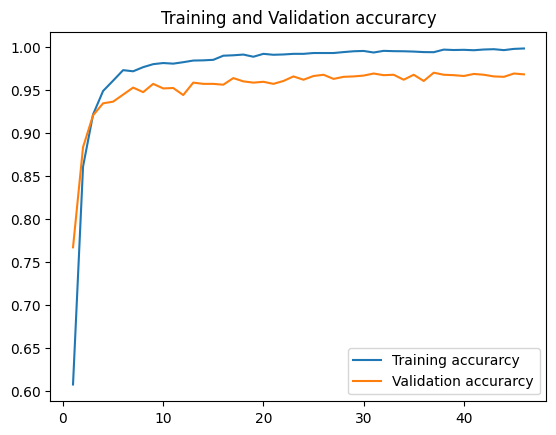

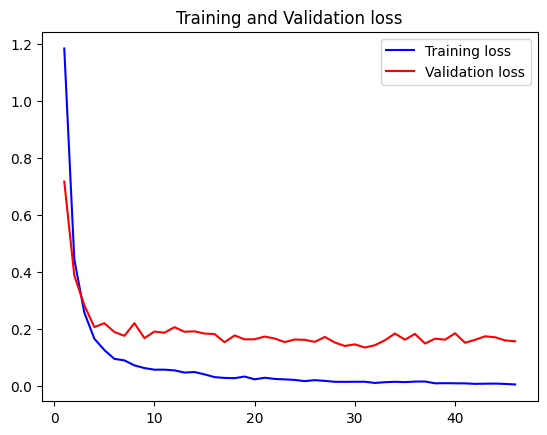

CPU times: user 620 ms, sys: 31.1 ms, total: 651 ms
Wall time: 1.57 s


In [13]:
%%time
temp = pd.DataFrame(history.history)
temp.to_csv('model_xception_history.csv', index=False)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, label='Training accurarcy')
plt.plot(epochs, val_acc, label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [14]:
print('test images')
for filepath in glob.glob(train_path+'/*'):
    files = glob.glob(filepath + '/*')
    print(f"{len(files)} \t {Path(filepath).name}")

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=train_path,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=1,
    #classes=['.'],
    #class_mode="categorical",
    class_mode=None,
    shuffle=False,
    seed=SEED)

test images
337 	 bacterial_panicle_blight
479 	 bacterial_leaf_blight
1442 	 dead_heart
1764 	 normal
380 	 bacterial_leaf_streak
965 	 brown_spot
1088 	 tungro
1738 	 blast
1594 	 hispa
620 	 downy_mildew
Found 10407 images belonging to 10 classes.


In [15]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
#test_generator.reset()

model.load_weights('xception.weights.best.hdf5')
pred = model.predict_generator(test_generator,
                               steps=STEP_SIZE_TEST,
                               verbose=1)
pred_classes = np.argmax(pred, axis=1)

10407/10407 [==============================] - 107s 10ms/step


In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

class_names = test_generator.class_indices.keys()
true_classes = test_generator.classes

acc = accuracy_score(true_classes, pred_classes)
print("xception Model Accuracy : {:.2f}%".format(acc * 100))

cls_report = classification_report(true_classes, pred_classes,
                                   target_names=class_names, digits=5)
print(cls_report)

xception Model Accuracy : 98.75%
                          precision    recall  f1-score   support

   bacterial_leaf_blight    0.98337   0.98747   0.98542       479
   bacterial_leaf_streak    0.97668   0.99211   0.98433       380
bacterial_panicle_blight    0.98240   0.99407   0.98820       337
                   blast    0.98514   0.99194   0.98853      1738
              brown_spot    0.98959   0.98549   0.98754       965
              dead_heart    0.99585   0.99931   0.99758      1442
            downy_mildew    0.95728   0.97581   0.96645       620
                   hispa    0.99678   0.96989   0.98315      1594
                  normal    0.99487   0.98866   0.99175      1764
                  tungro    0.97828   0.99357   0.98586      1088

                accuracy                        0.98751     10407
               macro avg    0.98402   0.98783   0.98588     10407
            weighted avg    0.98761   0.98751   0.98751     10407



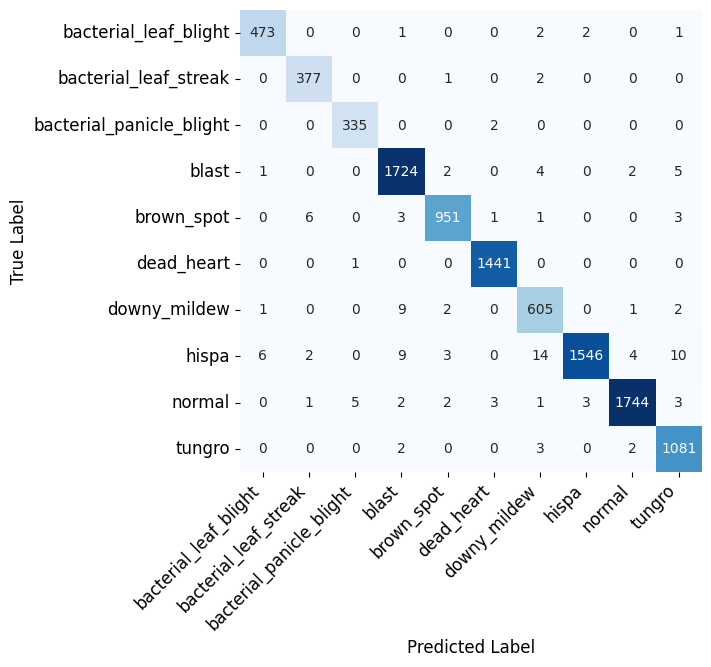

[[ 473    0    0    1    0    0    2    2    0    1]
 [   0  377    0    0    1    0    2    0    0    0]
 [   0    0  335    0    0    2    0    0    0    0]
 [   1    0    0 1724    2    0    4    0    2    5]
 [   0    6    0    3  951    1    1    0    0    3]
 [   0    0    1    0    0 1441    0    0    0    0]
 [   1    0    0    9    2    0  605    0    1    2]
 [   6    2    0    9    3    0   14 1546    4   10]
 [   0    1    5    2    2    3    1    3 1744    3]
 [   0    0    0    2    0    0    3    0    2 1081]]


In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_heatmap(true_classes, pred_classes, class_names, ax, title="CNN")

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()
cm = confusion_matrix(true_classes, pred_classes)
print(cm)

In [18]:
loss, acc = model.evaluate_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)
print(acc, loss)

10407/10407 [==============================] - 69s 7ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
0.0 0.0


In [19]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_datagen.class_indices)

labels = (train_datagen.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

pd.Series(predictions).value_counts()

normal                      1753
blast                       1750
hispa                       1551
dead_heart                  1447
tungro                      1105
brown_spot                   961
downy_mildew                 632
bacterial_leaf_blight        481
bacterial_leaf_streak        386
bacterial_panicle_blight     341
Name: count, dtype: int64

In [20]:
filenames=test_generator.filenames

results=pd.DataFrame({"image_id":filenames,
                      "label":predictions})
results.image_id = results.image_id.str.replace('./', '')
results.to_csv("submission.csv",index=False)
results.head()

,image_id,label
0,bacterial_leaf_blight/100023.jpg,bacterial_leaf_blight
1,bacterial_leaf_blight/100049.jpg,bacterial_leaf_blight
2,bacterial_leaf_blight/100126.jpg,bacterial_leaf_blight
3,bacterial_leaf_blight/100133.jpg,bacterial_leaf_blight
4,bacterial_leaf_blight/100148.jpg,bacterial_leaf_blight


In [21]:
labels=labels
model=model

In [ ]:
import pickle

with open('model_labels.pkl', 'wb') as file:
    pickle.dump(labels, file)

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)